<!-- <div style="text-align:center;">
    <img src="npslogo.webp" alt="AIS_image" width="600"> -->
<div style="text-align:center; font-size:48px;"><b>Near Real-Time AIS Tracking</b></div>

<div style="text-align:center; font-size:24px;"><b>Project Team:</b> Stuart Allison, Thomas Patterson, Nick Thanos</div>
<div style="text-align:center; font-size:18px;">20 November 2025</div>

<div style="text-align:center;">
<img src="AIS-Testimonial.webp" alt="AIS_image" width="500">
 <!-- #<img src="aisstream.webp" alt="AISStream" height="300"> -->
</div>




<p style="font-size:24px;"><b>Project Description:</b>  This project delivers an end-to-end streaming analytics pipeline for AIS data, combining real-time ingestion, parallel analytics, and HPC operations. Our outcomes include <b>data-driven insights into maritime traffic flow and anomalies near a specific port, API streaming, Bash automation, virtual environments, and visualizations.  </b>

# <b><u>Libraries and Virtual Environments</u></b>

<div style='font-size:24px;'>
First, we read in all the necessary libraries

In [6]:
### for API
import json
import os
import re
import asyncio
import websockets

### for visualizations
from datashader.utils import lnglat_to_meters
from holoviews.element.tiles import EsriImagery
import holoviews as hv, pandas as pd, colorcet as cc
import hvplot.pandas
from holoviews.element.tiles import CartoDark
import holoviews as hv
from bokeh.io import output_notebook, show
output_notebook()  # makes Bokeh plots render in notebook
import panel as pn
pn.extension()
hv.extension('bokeh')


### for geojson visualization, timeline visualization
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.cm as cm
from datetime import datetime, timezone
import folium
from folium.plugins import HeatMapWithTime
import matplotlib.colors as mcolors
import branca.colormap as bcm

### for .parquet file refresh
import paramiko
from getpass import getpass

### to get visualizations to display in HTML
from IPython.display import IFrame

Loading BokehJS ...

<p style='font-size:24px'>
Originally, we used an API to pull near-live AIS data to visualize locations. However, the bokeh package has version compatibility issues with the most recent python version, so we created a new virtual environment to create this presentation.  In doing so, we learned it was easy to transfer upload the exact requirements for the venv:

<p style='font-size:24px'>

``` text(base)
# Step 1: Create a new environment folder
python3 -m venv myenv

# Step 2: Activate the environment
source myenv/bin/activate

# Step 3: Install packages from requirements.txt
pip install -r requirements.txt

head requirements.txt 
affine==2.4.0
appnope @ file:///home/conda/feedstock_root/build_artifacts/appnope_1733332318622/work
asttokens @ file:///home/conda/feedstock_root/build_artifacts/asttokens_1733250440834/work
attrs==25.4.0
beautifulsoup4==4.14.2
bleach==6.3.0
bokeh==3.8.0
branca==0.8.2
Cartopy==0.25.0
certifi==2025.10.5


```

In [7]:
!pip install "jupyter_bokeh==3.0.7" "bokeh==3.4.1" "ipywidgets==8.1.2"


# <u><b>Data Collection and Preparation</b></u>

<img src="FBD22118-D6E0-4540-B337-E5A55E4DEB6A.jpeg" width="800">


<p style='font-size:24px'>
    Moving on to our API, our code was taken and adapted from <a href=https://aisstream.io/documentation>aisstream.io</a>, and pulls live ship tracking messages from land-based antennas.  We looked through the xml attributes of the different message types and ultimately pulled two different messages.  

<p style='font-size:24px'>
Below is a typical dynamic attribute from message type <code>PositionReport</code>


```text
{
   "Message":{
      "PositionReport":{
         "Cog":308,
         "CommunicationState":81982,
         "Latitude":66.02695,
         "Longitude":12.253821666666665,
         "MessageID":1,
         "NavigationalStatus":15,
         "PositionAccuracy":true,
         "Raim":false,
         "RateOfTurn":4,
         "RepeatIndicator":0,
         "Sog":0,
         "Spare":0,
         "SpecialManoeuvreIndicator":0,
         "Timestamp":31,
         "TrueHeading":235,
         "UserID":259000420,
         "Valid":true
      }
   },
   "MessageType":"PositionReport",
   "MetaData":{
      "MMSI":259000420,
      "ShipName":"AUGUSTSON",
      "latitude":66.02695,
      "longitude":12.253821666666665,
      "time_utc":"2022-12-29 18:22:32.318353 +0000 UTC"
   }
}

```

<p style='font-size:24px'>
And below is a typical static attribute from message type <code>ShipStaticData</code>

```text
{
  "AisVersion": 2,
  "CallSign": "LBHF",
  "Destination": "COASTGUARD@@@@@@@@H",
  "Dimension": {
    "A": 20,
    "B": 27,
    "C": 7,
    "D": 7
  },
  "Dte": false,
  "Eta": {
    "Day": 0,
    "Hour": 0,
    "Minute": 0,
    "Month": 0
  },
  "FixType": 1,
  "ImoNumber": 9353333,
  "MaximumStaticDraught": 4.5,
  "MessageID": 5,
  "Name": "KV FARM",
  "RepeatIndicator": 0,
  "Spare": false,
  "Type": 55,
  "UserID": 257069200,
  "Valid": true
}
```

<p style='font-size:24px'>
We modified the code to set a duration, then stored the data into a <code>.json</code> file, which was then read into a pandas dataframe for visualization.

In [8]:
######## Note: takes ~ 20s to run, as it pulls positionreports for 15 seconds, then reads to json, etc ###############
async def connect_ais_stream(duration = 5):
        
    async with websockets.connect("wss://stream.aisstream.io/v0/stream") as websocket:
        ais_data = []
        subscribe_message = {"APIKey": "f2db622b805da931e6b1e6609ceb659b355512ed",  # Required !
                             "BoundingBoxes": [[[-90, -180], [90, 180]]]} # Required!

        subscribe_message_json = json.dumps(subscribe_message)
        await websocket.send(subscribe_message_json)

        end_time = asyncio.get_event_loop().time() + duration

        while asyncio.get_event_loop().time() < end_time:
            try:
                message_json = await websocket.recv()
                message = json.loads(message_json)
                if message.get("MessageType") == "PositionReport":
                    ais_data.append(message['MetaData'])
            except Exception as e:
                print(f"Error receiving message: {e}")
                break
        with open(f"ais_data_{datetime.now().strftime('%m%d_%H%M')}.json",'w') as f:
            json.dump(ais_data,f)
        return(ais_data)
    
api_data_store = {}
api_data_store[f"api_data_{datetime.now().strftime('%d%m_%H%M')}"] = await connect_ais_stream(duration=5)
api_df = pd.DataFrame()
for key in api_data_store.keys():
    api_df = pd.concat([api_df, pd.DataFrame(api_data_store[key])],ignore_index=True)

#note: code taken/adapted from AISStream.io instruction page
    

# <u><b>Initial Visualization</b></u>

<p style='font-size:24px'>
We now use bokeh to visualize the 15 seconds of ship locations that we just pulled:

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
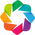

BokehModel(combine_events=True, render_bundle={'docs_json': {'4a6dfeb0-953c-4641-95ed-ba987f2e6894': {'version…

In [10]:
hv.extension('bokeh')

xlim = (-2.2e7, 2.5e7)
ylim = (-1.2e7, 1.5e7)

api_df.loc[:, 'x'], api_df.loc[:, 'y'] = lnglat_to_meters(api_df['longitude'], api_df['latitude'])

map_tiles = CartoDark().opts(alpha=0.5, width=1200, height=800, bgcolor='black', xlim=xlim, ylim=ylim)
plot = api_df.hvplot(
    'x', 
    'y', 
    kind='scatter', 
    rasterize=True, 
    cmap=cc.fire, 
    cnorm='eq_hist',  
    colorbar=True).opts(colorbar_position='bottom', title= 'Heatmap of AIS Locations', xlabel='',ylabel='')
# map_tiles * plot

app = pn.panel(map_tiles * plot)
app.servable()

### code taken and adopted from https://towardsdatascience.com/plotting-heat-maps-in-python-using-bokeh-folium-and-hvplot-eb7c7f49dbc6/ ####

# <u><b>Data Collection and Preparation II: Scheduling</b></u>

<p style='font-size:24px'>
This looks great, but we wanted to continually capture data at regular intervals over a period of time.  To do this, we created a python and batch script on HPC.


```text
async def connect_ais_stream(duration = 300):

    # async with websockets.connect("wss://stream.aisstream.io/v0/stream") as websocket:
    #     subscribe_message = {"APIKey": "f2db622b805da931e6b1e6609ceb659b355512ed",  # Required !
    #                          "BoundingBoxes": [[[-90, -180], [90, 180]]], # Required!
    #                          "FiltersShipMMSI": ["368207620", "367719770", "211476060"], # Optional!
    #                          "FilterMessageTypes": ["PositionReport"]} # Optional!
        
    async with websockets.connect("wss://stream.aisstream.io/v0/stream") as websocket:
        ais_data = []
        ship_data = []
        subscribe_message = {"APIKey": "f2db622b805da931e6b1e6609ceb659b355512ed",  ######### YOUR API HERE ###############
                             "BoundingBoxes": [[[-90, -180], [90, 180]]]} # Required!

        subscribe_message_json = json.dumps(subscribe_message)
        await websocket.send(subscribe_message_json)

        end_time = asyncio.get_event_loop().time() + duration

        while asyncio.get_event_loop().time() < end_time:
            try:
                message_json = await websocket.recv()
                message = json.loads(message_json)
                if message.get("MessageType") == "PositionReport":
                    ais_data.append(message['MetaData'])
                if message.get("MessageType") == "ShipStaticData":
                    ship_data.append({
                        'ShipStaticData': message['Message']['ShipStaticData'],
                        'MetaData': message['MetaData']
                    })

            except Exception as e:
                print(f"Error receiving message: {e}")
                break

            ####### SAVES EACH API PULL TO PWD WITH TIME AND DATE #####################
        with open(f"data_output/ais_data_{datetime.now().strftime('%m%d_%H%M')}.json",'w') as f:
            json.dump(ais_data,f)
        with open(f"ship_data/ship_data_{datetime.now().strftime('%m%d_%H%M')}.json",'w') as f:
            json.dump(ship_data,f)
        return(ais_data)
    

if __name__ == "__main__":
    asyncio.run(connect_ais_stream(duration=300))
```

<p style='font-size:24px'>
And batch script:

```text
#!/bin/sh
#SBATCH --output=print_output/out_ex1.txt

. /etc/profile
##module load lang/python
source /smallwork/$USER/comp3/bin/activate

cd /home/stuart.allison/project

python /home/stuart.allison/project/AIS.py
```

<p style='font-size:24px'>
Then, we learned about the scheduling mechanism on SLURM, <b>crontab</b>:

```text
 ┌───────────── minute (0 - 59)
 │ ┌───────────── hour (0 - 23)
 │ │ ┌───────────── day of month (1 - 31)
 │ │ │ ┌───────────── month (1 - 12 or jan-dec)
 │ │ │ │ ┌───────────── day of week (0 - 7, Sunday=0 or 7)
 │ │ │ │ │
 * * * * *  command-to-execute
```

```text 
crontab -e
5 * * * * sbatch /home/stuart.allison/project/scheduled.sh
20 * * * * sbatch /home/stuart.allison/project/scheduled_data.sh
```

<p style='font-size:24px'>
Now that we have scheduled the API pull, we can pull 5 minutes of ship tracks ever hour, on the hour. Below is an example of the .json files that are output by the script.

```text
[stuart.allison@submit-1 ship_data]$ ls | head -n 5
ship_data_1108_1210.json
ship_data_1108_1310.json
ship_data_1108_1410.json
ship_data_1108_1510.json
ship_data_1108_1610.json

[stuart.allison@submit-1 data_output]$ ls | head -n 5
ais_data_1103_1510.json
ais_data_1103_1610.json
ais_data_1103_1710.json
ais_data_1103_1810.json
ais_data_1103_1910.json
```

<p style='font-size:24px'>
    These were all combined into two separate parquet files, completed at 20 minutes after the hour, every hour

<p style='font-size:24px'>
    Next, we use the Paramiko library to retrieve the most current compiled AIS track and ship data from HPC. 
<p style='font-size:24px'>
    NOTE: This takes roughly 90 seconds to download roughly 600MB of parquet objects. Additionally, we discovered that GitLab has an HTTPS transfer threshold of around 400MB, so we had to install Git Large File Storage (LFS) with an SSH key to successfully commit and push updates to these .parquet files.

In [ ]:
# ######### CREATES LARGE FILES THAT NEED TO BE UPLOADED TO GITLAB VIA SSH ##############################
# #### only run to update parquet files from HPC #####

# username = getpass("Enter HPC username: ")
# password = getpass("Enter HPC password: ")

# ssh = paramiko.SSHClient()
# ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
# ssh.connect("hamming-sub1.uc.nps.edu", username=username, password=password)

# sftp = ssh.open_sftp()
# sftp.get("/home/stuart.allison/project/ais_data.parquet", "ais_data.parquet")
# sftp.get("/home/stuart.allison/project/ship_data.parquet", "ship_data.parquet")
# sftp.close()
# ssh.close()
# del(password)


In [ ]:
######### CLI commands in case VSCODE 
# !git add ais_data.parquet ship_data.parquet                          
# !git commit -m "Add parquet files via LFS"
# !git push origin main

<p style='font-size:24px'>
    Using the parquet files we just downloaded, we create dataframes for our visualization.  
<p style='font-size:24px'>NOTE: Though it is a large amount of data, many of the plotting methods we are using are specific to pandas.  The combined .jsons are around 2GB for only the track data, whereas the parquet files are only 600MB, so there are still considerable savings.

# <u><b>Visualization II: Cumulative Tracks (03 November to Present)</b></u>

In [ ]:
############# read in all location reports and ship data ######################
ais_df = pd.read_parquet('ais_data.parquet')
ship_df = pd.read_parquet('ship_data.parquet')

<p style='font-size:24px'>
    Now, we view our heatmap again, now containing hourly AIS tracks since 03 November

In [ ]:
############# HEATMAP GEO VISUALIZATION #############

############## DYNAMIC PLOT (ZOOMABLE, HOVERABLE) OF STATIC TRACK LOCATIONS **** ALL SHIPS *******###############
hv.extension('bokeh')

xlim = (-2.2e7, 2.5e7)
ylim = (-1.2e7, 1.5e7)

ais_df.loc[:, 'x'], ais_df.loc[:, 'y'] = lnglat_to_meters(ais_df['longitude'], ais_df['latitude'])

map_tiles = CartoDark().opts(alpha=0.5, width=1200, height=800, bgcolor='black',xlim=xlim, ylim=ylim)
plot = ais_df.hvplot(
    'x', 
    'y', 
    kind='scatter', 
    rasterize=True, 
    cmap=cc.fire, 
    cnorm='eq_hist',  
    colorbar=True).opts(colorbar_position='bottom', title= 'Heatmap of AIS Locations', xlabel='',ylabel='')

app = pn.panel(map_tiles * plot)
app.servable()

# pn.panel(map_tiles * plot).save('ais_heatmap.html', embed=False)



# <u><b>Data Collection and Preparation III: Unsanctioned Activity</b></u>

<p style='font-size:24px'>
This looks pretty but doesn't tell us a whole lot. We wanted to use this to view a certain kind of activity.  We were able to acquire data of commercial ships known to have entered and departed from Ukrainian ports currently illegally occupied by Russia.  There are comprehensive sanctions against any trade whatsoever with occupied Ukraine, so we make the assumption that these vessels are bypassing international sanctions (illegally).

In [ ]:
######### READ IN .XSL OF ILLEGAL SHIPS ##################
ukr_oil = pd.read_excel('visualisation_fleets.xlsx','Oil vessels')
ukr_grain = pd.read_excel('visualisation_fleets.xlsx','Grain vessels')
ukr_oil['commodity'] = 'oil'
ukr_grain['commodity'] = 'grain'
ukr_all = pd.concat((ukr_grain,ukr_oil))

<p style='font-size:24px'>
From the data source:

```text
Grain vessels = vessels that have been recorded in publicly available sources as shipping grain from occupied Ukraine, i.e., pillaged or stolen grain (sources available upon request)

Oil vessels = vessels that have shipped Russian oil, mostly in Black Sea and Baltic Sea, according to Black Sea News; it is unclear whether these are above or below the G7 price cap and therefore may or may not be sanctioned
```

In [ ]:
cols = ['Name','Fomer Name','IMO','Company Owner','Flag','Activity','commodity']
subset = ukr_all[cols]
pd.concat([subset.head(), subset.tail()])


<div style>


<p style='font-size:24px'>
    Lets make a plot of what flags these ships are currently operating under...

<p style='font-size:24px'>
    Unsurprisingly, the Russia is among the most common flag.  More suprising is the quantity of different countries.

In [ ]:
### Make a list of unique country names, removing x/a0 formatting ######
flag_list = list(ukr_all['Flag'].unique())
flag_list = [flag.replace('\xa0', ' ') if isinstance(flag, str) else flag
               for flag in flag_list]

### read in geo df from lab 3 
gdf = gpd.read_file('world_countries.json')
gdf = gdf[gdf['name'].isin(flag_list)]
gdf.head()

### center on the middle of our data points
lat_cent = ais_df['latitude'].mean()
lon_cent = ais_df['longitude'].mean()
m2 = folium.Map(location=[lat_cent, lon_cent], zoom_start=2, tiles="CartoDB dark_matter", width=1200,height=800 )

# Precompute ship counts by country
ship_counts = ukr_all.groupby('Flag')['IMO'].nunique().to_dict()

# Normalize counts for colormap
max_count = max(ship_counts.values()) if ship_counts else 1
norm = mcolors.Normalize(vmin=0, vmax=max_count)
cmap = cm.get_cmap('YlOrRd')

# Add a column to gdf with tooltip text
gdf['ship_count'] = gdf['name'].map(lambda c: ship_counts.get(c, 0))
gdf['tooltip_text'] = gdf.apply(lambda row: f"{row['name']} — Ships: {row['ship_count']}", axis=1)

# Add GeoJson with tooltip and dynamic color
folium.GeoJson(
    gdf,
    name='Ship_Flags',
    style_function=lambda feature: {
        'fillColor': mcolors.to_hex(cmap(norm(feature['properties']['ship_count']))),  #### chat helped adjust fills by number of ships
        'color': "#b36900",
        'weight': 1,
        'fillOpacity': 0.6
    },
    highlight_function=lambda feature: {
        'fillColor': mcolors.to_hex(cmap(norm(feature['properties']['ship_count']))),
        'color': 'orange',   # outline color when hovered
        'weight': 3,         # thicker border on hover
        'fillOpacity': 0.9   # stronger fill opacity on hover
    },
    tooltip=folium.GeoJsonTooltip(fields=['tooltip_text'], aliases=[''], sticky=True)
).add_to(m2)

# --- Add color scale legend --- #### From chat as well
import branca.colormap as bcm

# Build colormap directly from matplotlib cmap and your data range
colormap = bcm.LinearColormap(
    [mcolors.to_hex(cmap(i)) for i in np.linspace(0, 1, 256)],
    vmin=0, vmax=max_count,
    caption='Number of Ships'
)
colormap.caption_style = "color: white; font-size: 14px"
colormap.add_to(m2)


m2.save('flag_countries_map.html')
m2




<p style='font-size:24px'>
    We can see that most of the ships that are transferring oil or grain are using a flag of convenience (e.g. Liberia or Panama). We don't observe that countries with robust national flags (e.g. United States, Greece, United Kingdom).  We also observe that countries with robust flags (e.g. Greece) does not operate under other flags.

In [ ]:
subset[subset['Flag'] == 'Greece'].head()

<p style='font-size:24px'>
Companies operating under robust flags (Greece) typically do not operate under multiple flags:

In [ ]:
companies = list(subset[subset['Flag'] == 'Greece']['Company Owner'].unique())
greece_df = subset[(subset['Company Owner'].isin(companies)) & (subset['Flag'] != 'Greece')]
greece_df

<p style='font-size:24px'>
Below are the first five countries of the 300+ under the Liberian flag.  We observe that companies that operate under the Liberian flag also operate under other flags of convenience (e.g. Panama)

In [ ]:
subset[subset['Flag'] == 'Liberia'].head()

<p style='font-size:24px'>
Companies operating under flags of convenience operate under multiple flags:

In [ ]:
companies = list(subset[subset['Flag'] == 'Liberia']['Company Owner'].unique())
liberia_df = subset[(subset['Company Owner'].isin(companies)) & (subset['Flag'] != 'Liberia')]
liberia_df

<p style='font-size:24px'>
Different flags of convenience by Company Owner:

In [ ]:
for owner in list(liberia_df['Company Owner'].unique()):
    display(subset[subset['Company Owner'] == owner])

# <u><b>Visualization IV: Unsanctioned Activity, Through Time</b></u>

<p style='font-size:24px'>
    Our illegal activity data provided mostly IMO ship numbers, as they are more difficult to change to conceal identity, whereas the the <code>PositionReport</code> provided only MMSI.  We do some pandas filtering to cross reference the illegal activity IMO's with MMSI's, then plot our track data for ONLY these MMSI's.

<p style='font-size:24px'>
    Now, lets view our tracks of <b>only the illegal vessel traffic.</b> Unsurprisingly, there are now far fewer tracks. Also unsurprisingly, the focus areas are in and around Europe. 

<p style='font-size:24px'>
    There are far fewer 'grain' tracks, which is also predictable, given that these are much more likely to be illegal activity. 

In [ ]:
############# HEATMAP BY COMMODITY VISUALIZATION #############
# --- Data prep (your existing code) ---
oil_list = list(ship_df[ship_df['IMO'].isin(ukr_oil['IMO'])]['MMSI'].values)
grain_list = list(ship_df[ship_df['IMO'].isin(ukr_grain['IMO'])]['MMSI'].values)
oil_grain_list = list(ship_df[(ship_df['IMO'].isin(ukr_all['IMO'])) | 
                              (ship_df['IMO'].isin(ukr_all['IMO']))]['MMSI'].values)

ais_IMO_match = ais_df[ais_df['MMSI'].isin(oil_grain_list)]
ais_IMO_oil   = ais_df[ais_df['MMSI'].isin(oil_list)]
ais_IMO_grain = ais_df[ais_df['MMSI'].isin(grain_list)]

# Convert to web mercator coords
ais_IMO_grain.loc[:, 'x'], ais_IMO_grain.loc[:, 'y'] = lnglat_to_meters(
    ais_IMO_grain['longitude'], ais_IMO_grain['latitude']
)
ais_IMO_oil.loc[:, 'x'], ais_IMO_oil.loc[:, 'y'] = lnglat_to_meters(
    ais_IMO_oil['longitude'], ais_IMO_oil['latitude']
)

# --- Base map ---
map_tiles = CartoDark().opts(alpha=0.5, width=1200, height=800, bgcolor='black')

# --- Grain plot ---
plot_grain = ais_IMO_grain.hvplot(
    'x', 'y',
    kind='scatter',
    rasterize=True,
    cmap=cm.Blues_r,
    cnorm='eq_hist',
    colorbar=True
).opts(
    alpha=0.7,
    colorbar_position='bottom',
    title='Heatmap of AIS Grain Locations',
    xlabel='', ylabel=''
)

# --- Oil plot ---
plot_oil = ais_IMO_oil.hvplot(
    'x', 'y',
    kind='scatter',
    rasterize=True,
    cmap=cc.fire,
    cnorm='eq_hist',
    colorbar=True
).opts(
    alpha=0.7,
    colorbar_position='bottom',
    title='Heatmap of AIS Oil Locations',
    xlabel='', ylabel=''
)

####### CHAT HELPED WITH LAYER TOGGLING FUNCTION ##########
# --- Layer control widget ---
layer_selector = pn.widgets.CheckBoxGroup(
    name='Layers',
    value=['Oil', 'Grain'],   # default visible
    options=['Oil', 'Grain']
)


# --- Function to update overlay based on selection ---
def view(selected):
    base = map_tiles
    if 'Oil' in selected:
        base *= plot_oil
    if 'Grain' in selected:
        base *= plot_grain
    return base

# --- Bind widget to function ---
interactive_map = pn.bind(view, layer_selector)

# --- Final panel layout ---
dashboard = pn.Column(layer_selector, interactive_map)

# Save to HTML
dashboard.save('ais_illegal_ships_heatmap.html', embed=False)

# Show in notebook / server
dashboard


<p style='font-size:24px'>
    This looks better - it clearly shows some hot spots of activity, and also shows how far reaching this network is.  Additionally, it shows significant area in the Baltic and Mediterranean Seas, though this may be in part because of the source of the data.

<p style='font-size:24px'>
    Though this shows densities of activity, it doesn't necessarily show movements in time.  Greating a folium heatmap enables us to play it over time.  We group the tracks into hourly 'buckets', and visualize their respective locations as heatmaps through time.

In [ ]:
########### HEAT MAP VISUALIZATION OF ILLEGAL SHIPS WITH TIME SLIDE BAR ##############
import warnings
warnings.filterwarnings('ignore')

# Generate a gradient dictionary from inferno colormap
cmap = cm.get_cmap('inferno')
gradient = {i/10: mcolors.to_hex(cmap(i/10)) for i in range(11)}

# Convert time_utc if necessary
if not pd.api.types.is_datetime64_any_dtype(ais_IMO_match['time_utc']):
    ais_IMO_match['time_utc'] = pd.to_datetime(
        ais_IMO_match['time_utc'].str.replace(r' \+0000 UTC$', '', regex=True)
    )

# Time bucket (hourly)
ais_IMO_match['time_bucket'] = ais_IMO_match['time_utc'].dt.floor('H')

# Group and prepare data
grouped = ais_IMO_match.groupby('time_bucket')
heat_data = [group[['latitude', 'longitude']].values.tolist() for _, group in grouped]
time_index = [t.strftime('%Y-%m-%d %H:%M') for t in grouped.groups.keys()]

# Create the map
center_lat = ais_IMO_match['latitude'].mean()
center_lon = ais_IMO_match['longitude'].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=2,
    tiles='CartoDB dark_matter',
    width=1200,    # set width in pixels
    height=800 
)

# Add heatmap with time
HeatMapWithTime(
    heat_data,
    index=time_index,
    auto_play=False,
    max_opacity=0.8,
    radius=10,
    gradient=gradient
).add_to(m)

# --- Add orange semi-transparent circular markers ---
ports = {
    "Kerch": (45.3560, 36.4743),
    "Sevastopol": (44.6166, 33.5224),
    "Mariupol": (47.0971, 37.5434)
}

for name, (lat, lon) in ports.items():
    folium.CircleMarker(
        location=[lat, lon],
        radius=10,
        color='#84206b',
        fill=True,
        fill_color='#84206b',
        fill_opacity=0.5,
        popup=name
    ).add_to(m)

# Display inline
display(m)

# Optional: save (does NOT affect inline display)
m.save('ais_heatmap_with_time.html')


# <u><b>Conclusion and Future Work</b></u>

<p style='font-size:24px'>
<b>Future Work:</b> Continue developing these visualizations, adding filtering capability by commodity type, fleet owner, or flag.  Additionally, compiling all of the visualizations into a singular dashboard would be beneficial and allow for a better UI.  Finally, figuring out how to more effectively incorporate the live api data into an actually live feature would be valuable.

<p style='font-size:24px'>
Additionally, using paid membership or other service, track port of departure, destination port, etc to more robustly track potentially illegal activity. 

In [ ]:
# !jupyter nbconvert OA3802_FinalProject.ipynb --to html --template classic